# Lesson 2: Document Chunking Strategies

**Objective**: Learn how to effectively segment documents for better retrieval performance.

**Topics**:

- Chunking techniques: token-level, sentence-level, semantic-level
- Balancing context preservation with retrieval precision
- Small2Big and sliding window techniques

**Practical Task**: Implement chunking strategies on a sample dataset.

**Resources**:
- The five levels of chunking
- A guide to chunking
- [Visualizing chunking](https://chunkviz.up.railway.app/)
- [Full stack retrieval](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/a4570f3c4883eb9b835b0ee18990e62298f518ef/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

## Data loading, Chunking techniques y Text processing


### Level 1 - Character splitting

Es el metodo de *chunking* mas simple y basica, es el proceso por el cual solo dividimos el texto en *chunks* de tamaño *N* caracteres sin importar su contenido o forma.

Este metodo **NO** es recomendado para ninguna aplicación, pero puede ser un buen punto de partida para entender los fundamentos.

- Pros: facil y rapido
- Cons: Muy rigido y no toma en cuenta la estructura del texto

Conceptos:

- **Chunk size**: El número de caracteres que define el largo del chunk.
- **Chunk overlap**: La cantidad de caracteres que tiene que sobrelaparse en chunks secuenciales. Esto es para evitar cortar el contexto en multiples partes, perdiendo el significado semantico de algún pasaje. Esto creara duplicados entre los chunks.

#### Ejemplo manual

In [ ]:
from pprint import pprint

In [ ]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

# Creamos una lista vacía para guardar los chunks
chunks = []

# Definimos el tamaño de los chunks
chunk_size = 35

# Recorremos el texto en rangos de chunk_size
for i in range(0, len(text), chunk_size):
    chunk = text[i:i + chunk_size]
    chunks.append(chunk)
chunks

In [ ]:
len(chunks[0])

#### Usando el framework LangChain

- Normalmente para aplicaciones de RAG no trabajamos con strings, trabajamos con objetos del tipo **Document**. Estos objetos contienen el texto que queremos pero ademas contienen metadata adicional que permite hacer filtros mas complejos.

In [ ]:
pip install langchain

In [6]:
from langchain.text_splitter import CharacterTextSplitter

Cargamos el text splitter de LangChain, necesitamos especificar el chunk overlap y el separator, si no los entregamos tendremos resultados no deseados.

In [7]:
# Sin overlap
text_splitter = CharacterTextSplitter(
                    chunk_size = 35,
                    chunk_overlap=0,
                    separator='',
                    strip_whitespace=True)

In [8]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='unk up. It is the example text for'),
 Document(metadata={}, page_content='this exercise')]

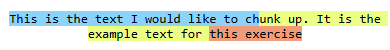

Si observamos logramos el mismo resultado que con la opción manual, pero ahora tenemos las estructuras de datos que son compatibles con el resto del framework. Ademas, pudimos hacer un poco de limpieza del string, en el caso del espacio en blanco de la segunda linea, utilizando strip_whitespace=True.

In [9]:
# Con overlap
text_splitter = CharacterTextSplitter(
                    chunk_size = 35,
                    chunk_overlap=4,
                    separator='',
                    strip_whitespace=True)
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='o chunk up. It is the example text'),
 Document(metadata={}, page_content='ext for this exercise')]

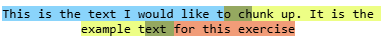

Si nos fijamos tenemos los mismos chunks, pero entre el chunk 1 y 2 y el chunk 2 y 3 algunos caracteres se repiten.

### Level 2: Recursive Character Text Splitting

Uno de los contras del metodo anterior es que no tomamos en cuenta la estructura del documentos. Simplemente contamos caracteres y cortamos. 

**Recursive Character Text Splitter** nos ayuda a considerar al menos la estructura del texto, vamos a especificar una serie de separadores que se usaran para separar nuestro docuemento.

Estos son los separadores disponibles:

- "\n\n" - Doble linea, un separador comun de parrafos.
- "\n" - Salto de linea, un separador comun de oraciones.
- " " - Espacio en blanco, un separador comun de palabras.
- "" - Caracter vacio, un separador comun de caracteres.

Este es la solución mas efectiva para comenzar a prototipar una aplicación rapidamente. Si no sabemos cual utilizar, esta es la primera opción para probar.

In [10]:
# Imports
from langchain.text_splitter import RecursiveCharacterTextSplitter

Vamos a probar un texto mas largo

In [11]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 65, chunk_overlap=0)

In [13]:
split_recursive_character = text_splitter.create_documents([text])
split_recursive_character

[Document(metadata={}, page_content="One of the most important things I didn't understand about the"),
 Document(metadata={}, page_content='world when I was a child is the degree to which the returns for'),
 Document(metadata={}, page_content='performance are superlinear.'),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear.'),
 Document(metadata={}, page_content='"You get out," I heard a thousand times, "what you put in." They'),
 Document(metadata={}, page_content='meant well, but this is rarely true. If your product is only'),
 Document(metadata={}, page_content="half as good as your competitor's, you don't get half as many"),
 Document(metadata={}, page_content='customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are"),
 Document(metadata={}, page_content='superlinear in business. Some think this is a flaw of'),
 Document(metadata=

Si nos fijamos, varios de los chunks terminana con un **"."**. Esto es porque probablemente son el fin de un parrafo y el splitter primero revisa si existe el doble salto de linea.

Una vez que los parrafos se separaron, el splitter mira el chunk size, si el demasiado grande, lo separa por el separador que sigue. Si el chunk sigue siendo muy largo, continua con todos los separadores.

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 450, chunk_overlap=0)
text_splitter.create_documents([text])

[Document(metadata={}, page_content="One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor\'s, you don\'t get half as many customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, th

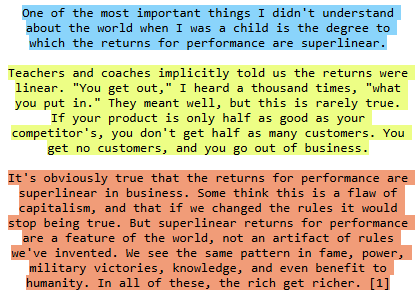



## Level 3: Document Specific Splitting

Seguimos aumentando la complejidad, ahora veamos distintos tipos de documentos distintos a un .txt. Que pasa si tenemos imagenes? es un PDF? o codigo?

Las aproximaciones anteriores no van a funcionar muy bien con este tipo de documentos.

Este nivel es todo acerca de ajustar la estrategia de **chunking** a nuestro caso de uso. Por ahora solo veremos como tratamos PDF complejos. Pero también podemos procesar otro tipo de archivos, como Markdown, Python, JS, etc.

### Markdown

In [ ]:
pip install langchain_community

In [15]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

In [16]:
pip install unstructured

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install markdown


In [17]:
markdown_path = "./example.md"
loader = UnstructuredMarkdownLoader(markdown_path, mode="elements")
data = loader.load()
data

[Document(metadata={'source': './example.md', 'category_depth': 0, 'languages': ['eng'], 'file_directory': '.', 'filename': 'example.md', 'filetype': 'text/markdown', 'last_modified': '2024-11-15T19:37:41', 'category': 'Title', 'element_id': 'ec60e3fdcbd7f78c6e9acfb3f3293d42'}, page_content='Introduction to Artificial Intelligence'),
 Document(metadata={'source': './example.md', 'languages': ['eng'], 'file_directory': '.', 'filename': 'example.md', 'filetype': 'text/markdown', 'last_modified': '2024-11-15T19:37:41', 'parent_id': 'ec60e3fdcbd7f78c6e9acfb3f3293d42', 'category': 'NarrativeText', 'element_id': '56f3e14dde7d37ff3009e4e0f066274b'}, page_content='Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn. These intelligent machines can perform tasks typically requiring human intelligence, such as visual perception, speech recognition, decision-making, and language translation.'),
 Document(metadata={'source':

In [18]:
pprint(data[6].page_content)

('Narrow AI, or Weak AI, refers to systems designed to handle specific tasks, '
 'such as facial recognition, voice assistants, or playing chess. These '
 'systems are highly effective in their respective areas but cannot perform '
 'tasks beyond their scope.')


In [19]:
data[6].metadata


{'source': './example.md',
 'languages': ['eng'],
 'file_directory': '.',
 'filename': 'example.md',
 'filetype': 'text/markdown',
 'last_modified': '2024-11-15T19:37:41',
 'parent_id': 'e26dc2c21f8449a68fce1bc8081575b8',
 'category': 'NarrativeText',
 'element_id': '08d627d409dd044fe0449898a9c14b26'}

### Python

In [20]:
from langchain.text_splitter import PythonCodeTextSplitter

In [21]:
python_text = """
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

for i in range(10):
    print (i)
"""

In [22]:
python_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)

In [23]:
python_splitter.create_documents([python_text])


[Document(metadata={}, page_content='class Person:\n  def __init__(self, name, age):\n    self.name = name\n    self.age = age'),
 Document(metadata={}, page_content='p1 = Person("John", 36)\n\nfor i in range(10):\n    print (i)')]

## Level 4: Semantic Chunking

Considerando que las metodologías anteriores solo consideran dividir el texto en largos fijos, o definidos por limitadores estaticos. No parece extraño que ninguna de esas aproximaciones no tome en contexto el contenido de los documentos?

Existe una mejor forma.

Los embeddings representan el significado semantico de un string, Por si mismos, no son muy utiles, pero cuando se comparan con otros, es posible inferir la relación entre distintos strings.

La hipotesis entonces es que chunks semanticamente similares deberían agruparse juntos.

In [24]:
from pprint import pprint
with open("./data/mit.txt") as file:
    essay = file.read()

pprint(essay)

('October 2006\n'
 '\n'
 '(This essay is derived from a talk at MIT.)\n'
 '\n'
 'Till recently graduating seniors had two choices: get a job or go to grad '
 'school. I think there will increasingly be a third option: to start your own '
 'startup. But how common will that be?\n'
 '\n'
 "I'm sure the default will always be to get a job, but starting a startup "
 'could well become as popular as grad school. In the late 90s my professor '
 "friends used to complain that they couldn't get grad students, because all "
 "the undergrads were going to work for startups. I wouldn't be surprised if "
 "that situation returns, but with one difference: this time they'll be "
 "starting their own instead of going to work for other people's.\n"
 '\n'
 'The most ambitious students will at this point be asking: Why wait till you '
 "graduate? Why not start a startup while you're in college? In fact, why go "
 'to college at all? Why not start a startup instead?\n'
 '\n'
 'A year and a half ago I gav

In [ ]:
pip install sentence_transformers

In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This is an example sentence', 'Each sentence is converted']

embeddings = model.encode(sentences)
print(embeddings.shape)

/opt/homebrew/anaconda3/envs/actividad_1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(2, 384)


In [28]:
pip install chunking.document_splitter

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement chunking.document_splitter (from versions: none)
ERROR: No matching distribution found for chunking.document_splitter
Note: you may need to restart the kernel to use updated packages.


In [29]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now import the DocumentSplitter class
from chunking.document_splitter import SemanticChunker

splitter = SemanticChunker(document=essay)

ModuleNotFoundError: No module named 'chunking.document_splitter'

In [ ]:
chunks = splitter.split_into_chunks(threshold=0.5)

Encontrar puntos de quiebre entre oraciones secuenciales - Luego intente un metodo de caminata. Comence en la primera oracion, obtuve el embedding, luego lo compare con la oracion #2, luego compare #2 y #3 y asi sucesivamente. Estaba buscando "puntos de quiebre" donde la distancia del embedding era grande. Si estaba por encima de un umbral, entonces lo considere el comienzo de una nueva sección semantica. Originalmente intente tomar embeddings de cada oracion, pero resulto ser demasiado ruidoso. Asi que termine tomando grupos de 3 oraciones (una ventana), luego obtuve un embedding, luego elimine la primera oracion y agregue la siguiente. Esto funciono un poco mejor.

Luego, quiero dividir todo el ensayo en chunks de 1 oración. Voy a dividir en "." "?" y "!". Hay mejores formas de hacer esto, pero esto es rápido y fácil por ahora.

In [ ]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} sentences were found")

Pero una lista de oraciones puede ser dificil de agregar mas datos. Voy a convertir esto en una lista de diccionarios (List[dict]), de los cuales, las oraciones seran una clave-valor. Luego podemos comenzar a agregar mas datos a cada oracion.

In [ ]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

Esto es lo que tenemos hasta ahora. Ahora, quiero agregar la oracion anterior y la siguiente a cada oracion. Esto nos ayudara a reducir el ruido y capturar mas de las relaciones entre oraciones secuenciales.

Cree una función para hacer esto, ya que lo usaremos mas adelante. El tamaño del buffer es configurable para que pueda seleccionar el tamaño de la ventana que desee. Mantenga este número en mente para los pasos posteriores. Solo usaré buffer_size=1 por ahora.

In [ ]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [ ]:
sentences[:3]

In [ ]:
len(sentences)

In [ ]:
pip install langchain_huggingface

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

dense_embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

Ahora creamos embeddings para cada oracion. Esto puede llevar un tiempo, asi que lo haremos en *batches* para acelerar el proceso.

In [ ]:
embeddings = dense_embedding_model.embed_documents([x['combined_sentence'] for x in sentences])

In [ ]:
len(embeddings)

In [ ]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [ ]:
type(sentence)

In [ ]:
sentence

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

Genial, ahora tenemos una lista de oraciones con sus embeddings y distancias. Ahora podemos comenzar a buscar puntos de quiebre.




In [ ]:
distances, sentences = calculate_cosine_distances(sentences)

In [ ]:
distances[:3]

Hm, yep, just a bunch of numbers that aren't fun to look at. Let's plot them.



In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances)

In [ ]:
import numpy as np

plt.plot(distances)

y_upper_bound = .9
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks")

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
            y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
            s=f"Chunk #{i}", horizontalalignment='center',
            rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i+1}",
                rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.

Because we have our breakpoints [23, 40, 51...] I want to make the first chunk 0-22, since the distance jumped on sentence 23.

In [ ]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [ ]:
chunks[0]

In [ ]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

## Level 5: Agentic Chunking

Tomando el nivel 4 un poco mas allá, podemos darle la misma instrucción a un LLM para que lo haga como lo haría un humano?

Pero, como es que un humano haría un chunking?. Basados en el nivel 4 podríamos seguir los siguientes pasos:

1. Tomamos una hoja de papel
2. Comenzariamos con la primera frase y asumimos que será el primer chunk, dado que no tenemos ningún otro.
3. Seguimos leyendo el documento y evaluando si es un nuevo chunk o es parte del chunk anterior o alguno existente. Si es similar a uno existente, lo concatenamos a ese chunk, si no, creamos uno nuevo.
4. Seguimos haciendo esto hasta que terminamos el documento.

In [ ]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

In [ ]:
from dotenv import load_dotenv

load_dotenv()

obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI(model='GPT-4o mini', openai_api_key = os.getenv("OPENAI_API_KEY"))

# Text processing



In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

file_path = (
    "./data/Regulaciones cacao y chocolate 2003.pdf"
)
loader = PyPDFLoader(file_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [ ]:
pprint(splits[0].page_content)


### Tokenization, POS and Dependency Parsing

In [ ]:
import spacy
# antes de corred la celda: python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")
single_doc = nlp(splits[0].page_content)

def tokenize_text(doc):
    return[{
        "text": token.text,
        "position": token.pos_,
        "dep": token.dep_,
    } for token in doc]
tokenize_text(single_doc)

for token in tokenize_text(single_doc):
    print(token)

### Stopwords removal


In [ ]:
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

def remove_stopwords(doc):
    return [token for token in doc if token.text.lower() not in spacy_stopwords]

filtered_tokens = remove_stopwords(single_doc)

# Print the first few filtered tokens to verify
for token in filtered_tokens[:10]:
    print(token.text)

### Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

#example
text = "running runners run easily jumper jumps jumping"

doc = nlp(text)

# apply stemming
stemmed_tokens = [stemmer.stem(token.text) for token in doc]

stem_text = " ".join(stemmed_tokens)

print("original text", text)
print("stemmed text", stem_text)

### Lemmatization

In [ ]:
def lemmatize_text(doc):
    return [token.lemma_ for token in doc]

lemmatized_tokens = lemmatize_text(single_doc)
print(lemmatized_tokens[:10]) 